# Classification Modeling

In [1]:
import classifiers as clf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

### Load Species Data

In [2]:
species = pd.read_pickle("../Data/species.pkl")
species.head()

,Scientific Name,Common Name,Federal Listing Status,Group_Amphibians,Group_Annelid Worms,Group_Arachnids,Group_Birds,Group_Clams,Group_Conifers and Cycads,Group_Corals,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,Accipiter gentilis,Northern goshawk,Not Listed,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acipenser fulvescens,Lake sturgeon,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acipenser oxyrinchus (=oxyrhynchus) desotoi,Atlantic sturgeon (Gulf subspecies),Threatened,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agarodes alabamensis,[Unnamed] caddisfly,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agrimonia incisa,Incised groovebur,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set Target and Feature Variables

In [3]:
# Create target and feature variables
y = species['Federal Listing Status']
X = species.drop(['Federal Listing Status', 'Scientific Name', 'Common Name'], axis = 1)

### Create Training and Test Sets

In [4]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# federal listing status
print('Training Data: ' + str(y_train.count()))
print('Endangered:    ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed:    ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened:    ' + str((y_train == 'Threatened').sum() / y_train.count()))

# federal listing status
print('Test Data:     ' + str(y_test.count()))
print('Endangered:    ' + str((y_test == 'Endangered').sum() / y_test.count()))
print('Not Listed:    ' + str((y_test == 'Not Listed').sum() / y_test.count()))
print('Threatened:    ' + str((y_test == 'Threatened').sum() / y_test.count()))

Training Data: 9389
Endangered:    0.15922888486526787
Not Listed:    0.7721802108850783
Threatened:    0.06859090424965385
Test Data:     2348
Endangered:    0.17206132879045996
Not Listed:    0.762350936967632
Threatened:    0.065587734241908


### Baseline Classification Model Parameters

In [5]:
# list for all classifiers
classifiers = []

# dummy classifier
classifiers.append({'Model': 'Dummy',
                    'Classifier': DummyClassifier(strategy='most_frequent')})

# logistic regression classifer
classifiers.append({'Model': 'Logistic Regression',
                    'Classifier': LogisticRegression(C=1e12,
                                                     penalty='l1',
                                                     multi_class='ovr',
                                                     solver='liblinear',
                                                     n_jobs=-1)})

# k nearest neighbors classifer
classifiers.append({'Model': 'K Nearest Neighbors',
                    'Classifier': KNeighborsClassifier(n_neighbors=5)})

# decision tree classifer
classifiers.append({'Model': 'Decision Tree',
                    'Classifier': DecisionTreeClassifier(criterion='gini',
                                                         max_depth=5,
                                                         max_features=0.8)})

# random forest classifer
classifiers.append({'Model': 'Random Forest',
                    'Classifier': RandomForestClassifier(n_estimators=100,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=0.8)})

In [6]:
classifiers, metrics = clf.classify(classifiers, X_train, X_test, y_train, y_test)

baseline = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])
baseline['Configuration'] = 'Baseline'
models = baseline.copy()
models

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
0,Dummy,Train,0.772180,0.596262,0.772180,0.672914,Baseline
1,Dummy,Test,0.762351,0.581179,0.762351,0.659550,Baseline
2,Logistic Regression,Train,0.810523,0.782194,0.810523,0.767010,Baseline
3,Logistic Regression,Test,0.802811,0.769197,0.802811,0.760842,Baseline
4,K Nearest Neighbors,Train,0.812014,0.792407,0.812014,0.793955,Baseline
5,K Nearest Neighbors,Test,0.780664,0.752362,0.780664,0.760934,Baseline
6,Decision Tree,Train,0.810203,0.790297,0.810203,0.760431,Baseline
7,Decision Tree,Test,0.801959,0.799138,0.801959,0.752723,Baseline
8,Random Forest,Train,0.814570,0.795033,0.814570,0.767646,Baseline
9,Random Forest,Test,0.804940,0.801101,0.804940,0.758628,Baseline


In [7]:
baseline.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
K Nearest Neighbors  0.780664  0.812014  0.752362  0.792407  0.780664   
Random Forest        0.804940  0.814570  0.801101  0.795033  0.804940   
Logistic Regression  0.802811  0.810523  0.769197  0.782194  0.802811   
Decision Tree        0.801959  0.810203  0.799138  0.790297  0.801959   
Dummy                0.762351  0.772180  0.581179  0.596262  0.762351   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
K Nearest Neighbors  0.812014  0.760934  0.793955  
Random Forest        0.814570  0.758628  0.767646  
Logistic Regression  0.810523  0.760842  0.767010  
Decision Tree        0.810203  0.752723  0.760431  
Dummy                0.772180  0.659550  0.672914

### Handling Class Imbalance with SMOTE Oversampling

9389
Endangered: 0.15922888486526787
Not Listed: 0.7721802108850783
Threatened: 0.06859090424965385


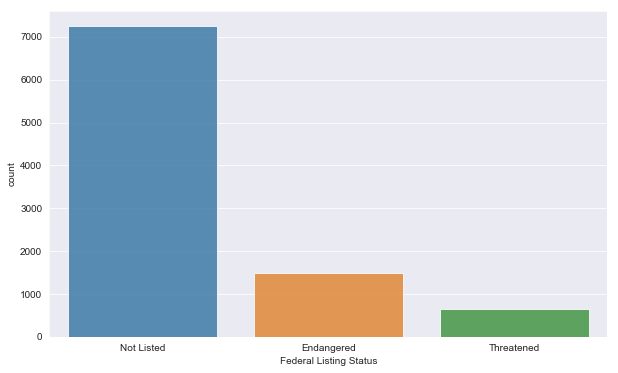

In [8]:
# federal listing status
print(y_train.count())
print('Endangered: ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed: ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened: ' + str((y_train == 'Threatened').sum() / y_train.count()))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train, alpha=0.8)

In [9]:
keys = list(y_train.unique())
values = np.ones((3), dtype=int) * (y_train == 'Not Listed').sum()
sample_ratio = dict(zip(keys, values))
sample_ratio

{'Not Listed': 7250, 'Endangered': 7250, 'Threatened': 7250}

21750
Endangered: 0.3333333333333333
Not Listed: 0.3333333333333333
Threatened: 0.3333333333333333


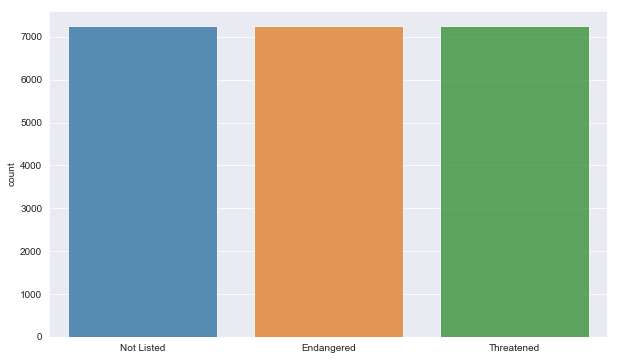

In [10]:
species['Federal Listing Status'].unique()

smote = SMOTE(ratio=sample_ratio)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# federal listing status
print(len(y_train_smote))
print('Endangered: ' + str((y_train_smote == 'Endangered').sum() / len(y_train_smote)))
print('Not Listed: ' + str((y_train_smote == 'Not Listed').sum() / len(y_train_smote)))
print('Threatened: ' + str((y_train_smote == 'Threatened').sum() / len(y_train_smote)))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_smote, alpha=0.8)

### Balanced Classification Models

In [11]:
classifiers, metrics = clf.classify(classifiers, X_train_smote, X_test, y_train_smote, y_test)

balanced = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])

balanced['Configuration'] = 'Balanced'
models = models.append(balanced, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

In [12]:
models.sort_values(by='F1 Score', ascending=False)

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
4,K Nearest Neighbors,Train,0.812014,0.792407,0.812014,0.793955,Baseline
8,Random Forest,Train,0.814570,0.795033,0.814570,0.767646,Baseline
2,Logistic Regression,Train,0.810523,0.782194,0.810523,0.767010,Baseline
13,Logistic Regression,Test,0.759370,0.765628,0.759370,0.761257,Balanced
5,K Nearest Neighbors,Test,0.780664,0.752362,0.780664,0.760934,Baseline
3,Logistic Regression,Test,0.802811,0.769197,0.802811,0.760842,Baseline
6,Decision Tree,Train,0.810203,0.790297,0.810203,0.760431,Baseline
9,Random Forest,Test,0.804940,0.801101,0.804940,0.758628,Baseline
15,K Nearest Neighbors,Test,0.770869,0.751052,0.770869,0.758088,Balanced
7,Decision Tree,Test,0.801959,0.799138,0.801959,0.752723,Baseline


In [13]:
balanced.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
Logistic Regression  0.759370  0.663126  0.765628  0.667875  0.759370   
K Nearest Neighbors  0.770869  0.663540  0.751052  0.685828  0.770869   
Random Forest        0.703578  0.600644  0.789792  0.615109  0.703578   
Decision Tree        0.711670  0.601517  0.779382  0.610950  0.711670   
Dummy                0.172061  0.333333  0.029605  0.111111  0.172061   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
Logistic Regression  0.663126  0.761257  0.656328  
K Nearest Neighbors  0.663540  0.758088  0.653646  
Random Forest        0.600644  0.737694  0.596239  
Decision Tree        0.601517  0.738700  0.594847  
Dummy                0.333333  0.050518  0.166667

### Tuned and Balanced Grid Search Classification Models

In [14]:
# list for all grid searches
grid_searches = []

In [15]:
# logistic regression parameters
parameters_log = dict(penalty=['l1', 'l2'],
                      C=[1e-2, 1e0, 1e2, 1e6, 1e12],
                      fit_intercept=[True, False],
                      multi_class=['ovr'],
                      solver=['liblinear'])

# grid search classifer
grid_searches.append({'Model': 'Logistic Regression',
                    'Classifier': GridSearchCV(LogisticRegression(),
                                               parameters_log,
                                               cv=5,
                                               scoring='f1_weighted',
                                               n_jobs=-1)})

In [16]:
grid_searches, metrics = clf.grid_search(grid_searches, X_train_smote, X_test, y_train_smote, y_test, X.columns)

tuned = pd.DataFrame(metrics, columns=['Model',
                                       'Split',
                                       'Accuracy',
                                       'Precision',
                                       'Recall',
                                       'F1 Score'])

tuned['Configuration'] = 'Balanced and Tuned'
models = models.append(tuned, ignore_index=True, sort=False)

In [17]:
models.sort_values(by='F1 Score', ascending=False)

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
4,K Nearest Neighbors,Train,0.812014,0.792407,0.812014,0.793955,Baseline
8,Random Forest,Train,0.814570,0.795033,0.814570,0.767646,Baseline
2,Logistic Regression,Train,0.810523,0.782194,0.810523,0.767010,Baseline
21,Logistic Regression,Test,0.759796,0.765945,0.759796,0.761555,Balanced and Tuned
13,Logistic Regression,Test,0.759370,0.765628,0.759370,0.761257,Balanced
5,K Nearest Neighbors,Test,0.780664,0.752362,0.780664,0.760934,Baseline
3,Logistic Regression,Test,0.802811,0.769197,0.802811,0.760842,Baseline
6,Decision Tree,Train,0.810203,0.790297,0.810203,0.760431,Baseline
9,Random Forest,Test,0.804940,0.801101,0.804940,0.758628,Baseline
15,K Nearest Neighbors,Test,0.770869,0.751052,0.770869,0.758088,Balanced


In [18]:
tuned.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision             Recall  \
Split                    Test     Train      Test    Train      Test   
Model                                                                  
Logistic Regression  0.759796  0.663218  0.765945  0.66801  0.759796   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
Logistic Regression  0.663218  0.761555  0.656426

In [ ]:
gs = GridSearchCV(LogisticRegression(), parameters_log, cv=5, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_train_smote,y_train_smote)

In [ ]:
# k nearest neighbors parameters
parameters_knn = dict(C=[0.001,0.01,0.1, 0.5, 1, 2, 5, 10,],
                      penalty=penalty['l1', 'l2'],
                      multi_class=['ovr'],
                      solver=['newton-cg'])

# grid search classifer
grid_searches.append({'Model': 'K Nearest Neighbors',
                    'Classifier': GridSearchCV(KNeighborsClassifier(), parameters_knn, cv=5, scoring='f1', n_jobs=-1)})

In [ ]:
# decision tree parameters
parameters_tree = dict(C=[0.001,0.01,0.1, 0.5, 1, 2, 5, 10,],
                       penalty=penalty['l1', 'l2'],
                       multi_class=['ovr'],
                       solver=['newton-cg'])

# grid search classifer
grid_searches.append({'Model': 'Decision Tree',
                    'Classifier': GridSearchCV(DecisionTreeClassifier(), parameters_tree, cv=5, scoring='f1', n_jobs=-1)})

In [ ]:
# random forest parameters
parameters_forest = dict(C=[0.001,0.01,0.1, 0.5, 1, 2, 5, 10,],
                         penalty=penalty['l1', 'l2'],
                         multi_class=['ovr'],
                         solver=['newton-cg'])

# grid search classifer
grid_searches.append({'Model': 'Random Forest',
                    'Classifier': GridSearchCV(RandomForestClassifier(), parameters_forest, cv=5, scoring='f1', n_jobs=-1)})

### Data Loading

In [ ]:
models.to_pickle("../Data/models.pkl")